Forked from main iowa_redistricting on march 28

manually implementing algorithm described in Chen and Rodden (2013)

Shapefile dataframes used in this notebook:
- shapefile_iowa: MGGG stuff merged with census stuff
- shapef_ia_proj: projected to UTM so we can run distance calculations on it
- shapef_ia_fordistricting: 99 rows for each county, ready for initial allocation; made from deep copy of shapef_ia_proj
- shapef_counties_for_realloc: made from a deep copy from shapef_ia_fordistricting; this has a num_switches column and a - district column populated with the district assignment from the initial allocation
- shapef_ia_initialdistricting: came from _fordistricting, went through the districting (step 1/2) process, and is now 4 - rows
	- as of Sept 18, not modified further for step 3/district balancing
- shapef_ia_redist: this is a deep copy of shapef_ia_initialdistricting with a few dropped columns. This df is used for - making new districts

In [1]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os       #mkdir
import datetime
from scipy.sparse import csgraph #for laplacian
from scipy.linalg import null_space
from plotnine import (ggplot, aes, geom_map, geom_text, geom_label,
                     ggtitle, element_blank, element_rect,
                     scale_fill_manual, theme_minimal, theme, scale_fill_cmap)
import math         ##for math.sqrt
import random       #for random selection of district to start with

/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# setting thresholds for helper functions
scale_pop_limit_by=4
max_switches_threshold=5
switches_range_proportion=.75
seed_number=16
random.seed(seed_number)
n_counties = 99
n_districts = 4

# Importing and Cleaning Data

## Importing data

In [3]:
#census.csv is data from Secretary of State's office.
census_df=pd.read_csv('census.csv')
census_df['COUNTYFP10']=census_df['COUNTYFP10'].astype(str).str.pad(3,fillchar='0')

#imports county shapefiles from MGGG
shapefile_iowa = gpd.read_file('IA_counties/IA_counties.shp').sort_values('NAME10',ignore_index=True)

## Merging ONLY 2020 population numbers and county_id from census df into shapefile_iowa
shapefile_iowa = shapefile_iowa.merge(census_df[['COUNTYFP10','population','county_id']], on='COUNTYFP10').copy()

county_populations = np.array(census_df['population'])
state_population = sum(county_populations)

#To determine the current coordinate reference system
# shapefile_iowa.crs
#Then project the shapefiles to UTM 15N
shapef_ia_proj = shapefile_iowa.to_crs(epsg=26915)

#checking out geopandas automatic distance calculation
# shapef_ia_proj['geometry'].iloc[0].distance(shapef_ia_proj['geometry'].iloc[1])
# adair-to-adams distance is 0, so shortest distance, not centroid-to-centroid


## Functions that create maps

In [4]:
#Population heat map
## Merging ONLY lat/long + county id from census df into shapefile_iowa (since population and county_id are already there)
# map_population_by_county_data = shapefile_iowa.merge(census_df[['COUNTYFP10','latitude','longitude']], on='COUNTYFP10').copy()

# map_population_by_county = (
#     ggplot(map_population_by_county_data)
#     + geom_map(aes(fill='population'))
#     + geom_label(aes(x='longitude', y='latitude', 
#                      label='NAME10',size=2), 
#                  show_legend=False)
#     + theme_minimal()
#     + theme(axis_text_x=element_blank(),
#             axis_text_y=element_blank(),
#             axis_title_x=element_blank(),
#             axis_title_y=element_blank(),
#             axis_ticks=element_blank(),
#             panel_grid_major=element_blank(),
#             panel_grid_minor=element_blank()
#            )
#     )
# map_population_by_county

#data_label: 'county_id', 'population', 'NAME10', 'county_id_string', etc
#second argument is the column from the dataframe that we want to sort by
#in our case, it should be 'DISTRICT' from the shapef_ia_redist dataframe
color_dict = { 1 : '#3995ff',
               2 : '#ff8539',
               3 : '#ffe839',
               4 : '#d139ff',
               }

def distmap_by_county(map_data,data_label):
    plot_distmap = (
        ggplot(map_data)
    + geom_map(aes(fill='DISTRICT')
        ,show_legend=True
        ) 
    + geom_label(aes(x='xcentr_lon', y='ycentr_lat', label=data_label,size=2)
        , show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            plot_background = element_rect(fill = 'white')       #whole png area
            )
    + scale_fill_manual(values=color_dict)        #uncomment this line to make district categorical!
    )
    return plot_distmap

#label_field: 'population', 'temp_district', 'combined_label'
def map_merged_districts(new_shapefile,label_field):
    map_population_by_district = (
        ggplot(new_shapefile)
        + geom_map(aes(fill='population'))
        + geom_label(aes(x='xcentr_lon', y='ycentr_lat', 
                        label=(label_field),size=2), 
                    show_legend=False)
        + theme_minimal()
        + theme(axis_text_x=element_blank(),
                axis_text_y=element_blank(),
                axis_title_x=element_blank(),
                axis_title_y=element_blank(),
                axis_ticks=element_blank(),
                panel_grid_major=element_blank(),
                panel_grid_minor=element_blank(),
                # panel_background = element_rect(fill = 'white'),    #just panel of the map itself
                plot_background = element_rect(fill = 'white')       #whole png area
            )
        + scale_fill_cmap(#cmap_name="PiYG",
           limits=[0,1500000])
        )

    return map_population_by_district

#input: shapefile of counties within a particular district 
#   (after undergoing identity overlay)
#   label_field options: 'NAME10', 'population_2', 'county_id', 'county_id_string_2', etc
def map_unmerged_districts(new_shapefile,label_field):
    map_counties_by_district = (
        ggplot(new_shapefile)
        + geom_map(aes(fill='population_2'))
        + geom_label(aes(x='xcentr_lon_2', y='ycentr_lat_2', 
                        label=label_field,size=2), 
                    show_legend=False)
        + theme_minimal()
        + theme(axis_text_x=element_blank(),
                axis_text_y=element_blank(),
                axis_title_x=element_blank(),
                axis_title_y=element_blank(),
                axis_ticks=element_blank(),
                panel_grid_major=element_blank(),
                panel_grid_minor=element_blank(),
                # panel_background = element_rect(fill = 'white'),    #just panel of the map itself
                plot_background = element_rect(fill = 'white')       #whole png area
            )
        )

    return map_counties_by_district

## Creating distance matrix for Iowa counties

In [5]:
# adding/fixing columns with (projected) centroid locations 
shapef_ia_proj['xcentr_lon'] = shapef_ia_proj.centroid.x
shapef_ia_proj['ycentr_lat'] = shapef_ia_proj.centroid.y

In [6]:
# cutting out other columns from the shapefile to be dissolved on

# 'TOTPOP' is the MGGG shapefile totpop (pre-2020), so removing
# also removing: the un-projected 'INTPTLAT10' and 'INTPTLON10'
#      and 'NAMELSAD10', the 2 word name
#      and all demographic/voting data
#      and (later on): also removing ALAND and AWATER, since they just get messy with merges and dissolves

districting_columns = ['COUNTYFP10', 'NAME10', 'geometry', 
       'population', 'county_id', 'xcentr_lon', 'ycentr_lat']

#make a new shapefile, which will be merged/dissolved on in the process of making districts
shapef_ia_fordistricting = shapef_ia_proj[districting_columns].copy()

#add column of county indices (which will get concatenated, as county_id_string)
shapef_ia_fordistricting['county_id_string'] = shapef_ia_fordistricting['county_id']
shapef_ia_fordistricting['county_id_string'] = shapef_ia_fordistricting['county_id_string'].astype(str).str.pad(2,fillchar='0')

#add column of county indices (which will become district indices)
shapef_ia_fordistricting['temp_district'] = shapef_ia_fordistricting.index

# Steps 1 and 2 initial allocation

## Nearest-Neighbor district-building model (adjacency matrix + distance matrix)

* To start, we have 99 districts, 1 for each county.
* Randomly select a district (single county at the moment!) to start with.
* Join it to its nearest neighbor (using centroid measurement of distance).
    * Make new shapefile with those two counties dissolved together (and calc new centroids/distances)
    * Now we have 98 districts. Repeat until 4 left.

This procedure preserves compactness well, but has no population controls.
After we're down to 4 districts, we will then swap counties between districts until populations stabilize.


In [7]:
# function for arbitrary adjacency matrix
# updated to no longer classify kitty-corner as "adjacent", Oct 30

def adj_mat_calc(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    adjac_mat = pd.DataFrame()
    for i in range(curr_n_districts):
        adjac_mat[i] = temp_shapefile.intersection(temp_shapefile.iloc[[i]].unary_union).length
    #sign function turns all nonzero entries to 1
    adjac_mat = np.sign(adjac_mat)
    #eliminate diagonals, so county i is not adjacent to itself
    adjac_mat = adjac_mat - np.identity(curr_n_districts)
    # make everything an integer
    adjac_mat = adjac_mat.astype(int)
    #and/or boolean?
    # ia_adjac_matrix_bool = ia_adjac_matrix.astype(bool)
    return adjac_mat

#function: input is a shapefile with centroid columns, output is a distance matrix
def temp_distance_matrix(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    distance_mat = np.zeros((curr_n_districts,curr_n_districts))

    for i in range(curr_n_districts):
        for j in range(i):      #just do half the triangle, so indices from 0 to i-1
            x_dist = (temp_shapefile['xcentr_lon'].iloc[i] - temp_shapefile['xcentr_lon'].iloc[j])
            y_dist = (temp_shapefile['ycentr_lat'].iloc[i] - temp_shapefile['ycentr_lat'].iloc[j])
            distance_mat[i,j] = math.sqrt(x_dist**2 + y_dist**2)
            distance_mat[j,i] = math.sqrt(x_dist**2 + y_dist**2)
    return distance_mat

## Initial allocation

In [8]:
shapef_ia_initialdistricting = shapef_ia_fordistricting.copy()

for i in range(95): ##### 95 iterations brings us from 99 districts to 4
    #how many districts are we working with this time?
    running_ndistricts = len(shapef_ia_initialdistricting)

    # pick out a district to work on on this iteration of the loop
    running_index = random.randint(0,running_ndistricts-1)        

    #find the temp_district associated with the running index
    #     the below was returning a slice of a dataframe, and not just the entry
    # running_temp_dist = shapef_ia_initialdistricting.loc[shapef_ia_initialdistricting.index == running_index, 'temp_district']
    running_temp_district = shapef_ia_initialdistricting['temp_district'].iloc[running_index]
    #     originally just called this for the print statement
         
    #set up adjacency and distance matrices
    running_adjmat = adj_mat_calc(shapef_ia_initialdistricting)
    running_distmat = temp_distance_matrix(shapef_ia_initialdistricting)

    # print("On loop # %d (with %d districts remaining), we have selected index %d. \
    # \n This corresponds to county id %s and temporary district # %d."   \
    #     % (i+1, running_ndistricts,running_index,   \
    #        shapef_ia_initialdistricting['county_id_string'].iloc[running_index], \
    #        running_temp_district) )
    
    #------find closest neighbor: could use cleaning up/making better
    distance_list = list(running_distmat[running_index])

    neighbor_dist = sorted(distance_list)[1]           #second smallest distance is nearest neighbor (since distance to self is zero)
    neighbor_index = distance_list.index(neighbor_dist)     
    
    # the temp_district number associated with the neighbor_index
    neighbor_temp_district= shapef_ia_initialdistricting['temp_district'].iloc[neighbor_index]
    
    #   this doesn't really get used except to print? but running_temp_district is super important for re-indexing

    # print("The nearest neighbor index is %d, representing county id %s and temporary district # %d." \
    #     % (neighbor_index,   \
    #        shapef_ia_initialdistricting['county_id_string'].iloc[neighbor_index],\
    #        neighbor_temp_district) )
    #---------end finding closest neightbor

    # re-index the neighbor county to be in the first county's district
    shapef_ia_initialdistricting.loc[shapef_ia_initialdistricting.index == neighbor_index, 'temp_district'] = running_temp_district      

    # dissolve shapefile based on temp_district to combine the two counties
    #aggregate remaining columns by summing them

    # arguments for aggfunc: https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html
    shapef_ia_initialdistricting = shapef_ia_initialdistricting.dissolve(
        by="temp_district",
        aggfunc = {
            "COUNTYFP10": "sum",    #sum = concatenation here b/c string
            "NAME10": "count",      #kind of dummy: will be 2 only for most-recently-merged district
            "population": "sum",
            "county_id": "sum",     #should be actual sum here, kind of dummy
            "xcentr_lon": "first",  #dummy, since we'll recalculate
            "ycentr_lat": "first",
            "county_id_string": "sum", #sum = concatenation here b/c string
            "temp_district": "first"
        }
    )

    # update centroid lat/longs!
    shapef_ia_initialdistricting['xcentr_lon'] = shapef_ia_initialdistricting.centroid.x
    shapef_ia_initialdistricting['ycentr_lat'] = shapef_ia_initialdistricting.centroid.y

    #the dissolve process makes the temp_district column into the index of the dataframe
    #which then has issues when we iterate the process
    #so dump the index for a dummy one now
    shapef_ia_initialdistricting = shapef_ia_initialdistricting.reset_index(drop=True)

    print("Districts remaining:", len(shapef_ia_initialdistricting))  #print how many districts are left

# shapef_ia_initialdistricting = shapef_ia_initialdistricting.copy()


Districts remaining: 98
Districts remaining: 97
Districts remaining: 96
Districts remaining: 95
Districts remaining: 94
Districts remaining: 93
Districts remaining: 92
Districts remaining: 91
Districts remaining: 90
Districts remaining: 89
Districts remaining: 88
Districts remaining: 87
Districts remaining: 86
Districts remaining: 85
Districts remaining: 84
Districts remaining: 83
Districts remaining: 82
Districts remaining: 81
Districts remaining: 80
Districts remaining: 79
Districts remaining: 78
Districts remaining: 77
Districts remaining: 76
Districts remaining: 75
Districts remaining: 74
Districts remaining: 73
Districts remaining: 72
Districts remaining: 71
Districts remaining: 70
Districts remaining: 69
Districts remaining: 68
Districts remaining: 67
Districts remaining: 66
Districts remaining: 65
Districts remaining: 64
Districts remaining: 63
Districts remaining: 62
Districts remaining: 61
Districts remaining: 60
Districts remaining: 59
Districts remaining: 58
Districts remain

### Checking district map and population distribution of initial allocation

In [9]:
shapef_ia_initialdistricting['combined_label'] = shapef_ia_initialdistricting['population'].astype(str)  + str(' (dist ') + shapef_ia_initialdistricting['temp_district'].astype(str) + str (')')
# shapef_ia_initialdistricting['combined_label']

map_merged_districts(shapef_ia_initialdistricting,'combined_label')

shapef_ia_initialdistricting[['population','temp_district']]

,population,temp_district
0,657470,16
1,1276088,30
2,937900,42
3,318911,50


# Step 3: Realloacting counties until population is within bounds

## Helper Functions

### Functions that don't deal directly with reallocation parameters
- pop_diff_matrix, 
- calculate_rel_distance 
- neighbor_pop_diff 
- dissolve_by_district 
- ideal_district_size
- big_dist_contiguity_check_func

In [10]:
# argument: shapefile of districts with merged counties
# output: population difference between all districts ((i,j)>0 iff pop(i)>pop(j))
def pop_diff_matrix(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    pop_diff_mat = np.zeros((curr_n_districts,curr_n_districts))

    for i in range(curr_n_districts):
        for j in range(curr_n_districts):   
            pop_diff_mat[i,j] = temp_shapefile['population'].iloc[i] - temp_shapefile['population'].iloc[j]
    
    return pop_diff_mat

# argument: shapefile of districts with merged counties
#output: population differences between ADJACENT neighboring districts 
#-----------module to find neighboring districts with the greatest population difference---------------------
def neighbor_popdiff_fun(df):
    #adjacencey matrix for 4 districts
    adj_mat_array = adj_mat_calc(df).to_numpy()   

    pop_diff_array = pop_diff_matrix(df)
    # zero out any pairs that aren't adjacent
    # for numpy arrays, "*" is piecewise multiplication
    neighbor_popdiff = adj_mat_array * pop_diff_array
    return neighbor_popdiff

# arguments: dataframe of movable counties, smaller district 
# output: relative distances for each border county
def calculate_rel_dist(border_counties,new_district):
    n_border_counties = len(border_counties)
    distance_list = np.zeros((n_border_counties,3))

    for i in range(n_border_counties):
        oldx_dist = border_counties['xcentr_lon_2'].iloc[i] - border_counties['xcentr_lon_1'].iloc[i]
        oldy_dist = border_counties['ycentr_lat_2'].iloc[i] - border_counties['ycentr_lat_1'].iloc[i]

        # old_dist
        distance_list[i,0] = math.sqrt(oldx_dist**2 + oldy_dist**2)

        newx_dist = border_counties['xcentr_lon_2'].iloc[i] - new_district['xcentr_lon'].iloc[0]
        newy_dist = border_counties['ycentr_lat_2'].iloc[i] - new_district['ycentr_lat'].iloc[0]

        # new_dist
        distance_list[i,1] = math.sqrt(newx_dist**2 + newy_dist**2)

        ## relative_distance: old - new
        # we'll move the county with highest relative distance
        distance_list[i,2] = distance_list[i,0] - distance_list[i,1]

    #we only need relative distances, not the component parts
    #so we could just make an n x 1 list instead of n x 3
    rel_dist = distance_list[:,2]
    return rel_dist

# argument:shapefile with attributes of single counties (and columns as labeled below)
#       usually:  shapef_ia_step3
# output:shapefile with attributes of districts
#       usually: shapef_step3_dissolved
def dissolve_by_district(county_shapefile):
    dissolved_shapefile = county_shapefile.dissolve(
        by="DISTRICT",
        aggfunc = {
            "population": "sum",
            "xcentr_lon": "first",  #dummy, since we'll recalculate
            "ycentr_lat": "first",
            #skip the county_id_string now since we aren't slicing it
            # "county_id_string": "sum", #sum = concatenation here b/c string
            "DISTRICT": "first"
        }
    )
    dissolved_shapefile['xcentr_lon'] = dissolved_shapefile.centroid.x
    dissolved_shapefile['ycentr_lat'] = dissolved_shapefile.centroid.y

    #the dissolve process makes the temp_district column into the index of the dataframe
    #which then has issues when we iterate the process
    #so dump the index for a dummy one now
    dissolved_shapefile = dissolved_shapefile.reset_index(drop=True)

    return dissolved_shapefile

#gives a range for district size based off of ideal district size
def ideal_district_size_func(state_population, n_districts, tolerance):
    ideal_district_size=state_population/n_districts
    district_maximum=int(ideal_district_size*(1+tolerance))
    district_minimum=int(ideal_district_size*(1-tolerance))
    return district_minimum, district_maximum

# arguments: border county to move and the bigger district
# output: dimension of nullspace of laplacian of the bigger district
def big_dist_contiguity_check_func(moving_index, big_dist_df):
    df=big_dist_df.loc[big_dist_df['county_id']!=moving_index]
    big_dist_laplacian=csgraph.laplacian(adj_mat_calc(df).to_numpy())
    return  null_space(big_dist_laplacian).shape[1]

### Functions that deal directly with reallocation parameters
- border_counties_df_func
- switch_func
- switches_threshold_func

In [11]:
#Identify the border counties between the two districts with biggest population difference
#return a dataframe with the border counties with a column of relative distances between the big and small districts
def border_counties_df_func(shapef_ia_redist, list_of_districts, list_of_counties,scale_pop_limit_by):
    neighbor_popdiff=neighbor_popdiff_fun(shapef_ia_redist)
    #popdiff_locs is a list of ordered pairs giving the location of the
    #positive values within neighbor_popdiff corresponding to adjacent districts. Note!! Indexed on (0,n-1)!
    popdiff_locs=np.argwhere(neighbor_popdiff>0)
    # maxpopdiff_loc = np.unravel_index(np.argmax(neighbor_popdiff, axis=None),   neighbor_popdiff.shape)

    big_dist_list=[]
    small_dist_list=[]
    pop_limit_switch_list=[]
    
    for i in range(popdiff_locs.shape[0]):
        big_dist_index=popdiff_locs[i][0]
        big_dist_list.append(big_dist_index)
        small_dist_index=popdiff_locs[i][1]
        small_dist_list.append(small_dist_index)
        pop_limit_switch=scale_pop_limit_by*neighbor_popdiff[big_dist_index][small_dist_index]
        pop_limit_switch_list.append(pop_limit_switch)

    df=pd.DataFrame()
    df['big_dist_index']=big_dist_list #goes from 0 to 3
    df['small_dist_index']=small_dist_list #goes from 0 to 3
    df['small_dist']=[x+1 for x in small_dist_list] #goes from 1 to 4
    df['big_dist']=[x+1 for x in big_dist_list] #goes from 1 to 4
    df['pop_limit_switch']=pop_limit_switch_list

    df=df.sort_values('pop_limit_switch', ascending=False).reset_index(drop=True)
    #Note: pop_limit_switch is a proxy for actual pop limits and we can sort off of this list. But we need to make sure other lists are sorted accordingly


    #----------find which county will be swapped from "bigdist" to  "smalldist"----------------------
    #from the list of 4 dataframes (each of diff districts)
    #we call the dataframe of the big district

        #dataframe of counties in the Big district which are 
    #adjacent to the Small district so which we might move
    #(possible to be point neighbors and have issues -
    #should be okay with D criterion, though)
    #reset index so it is (0,n-1), instead of sparse indexing based on where the county     was within the district
    #we retain the original county id in 'county_id'

    small_dist_list_for_border_counties=[]
    big_dist_counties_list=[]
    bigdist_movable_list=[]
    for j in range(popdiff_locs.shape[0]):
        # small_dist_list_for_border_counties=[x-1 for x in small_dist_list]
        small_dist_list_for_border_counties.append(list_of_districts[df.loc[j,'small_dist_index']])
        big_dist_counties_list.append(list_of_counties[df.loc[j, 'big_dist_index']])
        
        #update Nov 1
        #intersection  and .length finds the length of intersection
        #   of each county from the big district with the entirety of the small district
        #np.sign turns nonzero entries to 1s
        temp_movable_ones = np.sign(big_dist_counties_list[j].intersection(small_dist_list_for_border_counties[j].unary_union).length)
        temp_movable_boolean = temp_movable_ones.astype(bool)
        bigdist_movable_list.append(big_dist_counties_list[j].loc[temp_movable_boolean].reset_index(drop=True).copy())
        # end Nov 1 update

        #update the .intersects so that it avoids kitty corners
        # bigdist_movable_list.append(big_dist_counties_list[j].loc[big_dist_counties_list[j].intersection(small_dist_list_for_border_counties[j].unary_union)].reset_index(drop=True).copy())
        bigdist_movable_list[j]['relative_distance']=calculate_rel_dist(bigdist_movable_list[j], small_dist_list_for_border_counties[j])


    return bigdist_movable_list, df['pop_limit_switch'].tolist(), df['small_dist'].tolist(), df['big_dist_index'].tolist()

#modifying switch_threshold_func to take a list of dataframes as an argument
# arguments: dataframe of border counties, max switches threshold, range threshold for switches range
# output: a number for the switches threshold for that particular border county dataframe
def switch_threshold_func(dataframe_movable_list,max_switches_threshold,switches_range_proportion):
    switches_threshold=[]
    for j in range(len(dataframe_movable_list)):
        # array with all switch counts from the movable county list
        num_switches_array = np.array(dataframe_movable_list[j]['num_switches'])

        # max and min values from the array
        max_switches = max(num_switches_array)
        min_switches = min(num_switches_array)
        # our chosen threshold for switches: halfway between max and min (floor)
        if max_switches<max_switches_threshold:
            switches_threshold.append(max_switches)
        else:
            switches_threshold.append(min_switches + np.ceil((max_switches-min_switches)*switches_range_proportion))
    return switches_threshold

# arguments: list of big districts, list of all counties, list of border counties for adjacent districts, switches threshold for each pair of districts, 
# population threshold for getting moved, list of small districts
# outputt: index of county to switch prioritized by: relative distance, switches threshold, population
def switch_func(big_dist_list, list_of_counties, dataframe_movable_list,switches_threshold_list,pop_limit_switch_list,small_dist_list):
    for j in range(len(dataframe_movable_list)):
        dataframe_sorted = dataframe_movable_list[j].sort_values('relative_distance',ascending=False).copy()
        switches_threshold = switches_threshold_list[j]
        pop_limit_switch = pop_limit_switch_list[j]
        for i in range(dataframe_sorted.shape[0]):
            big_dist_index=big_dist_list[j]
            if (dataframe_sorted.iloc[i]['num_switches'] <= switches_threshold) & (dataframe_sorted.iloc[i]['population_2']<pop_limit_switch) &(big_dist_contiguity_check_func(dataframe_sorted.iloc[i]['county_id'],list_of_counties[big_dist_index])==1):
                return dataframe_sorted.iloc[i]['county_id'], small_dist_list[j]
                break

## Main part of reallocation

Pseudo code for initial allocation and reallocation:
(COMPLETED ON 9/20)

1. Initial allocation (complete)
    - Prep gpdf for initial allocation
    - Create the dataframe with all 99 counties and their district assignments (shapef_ia_fordistricting)
    - Treat all 99 counties as its own district
    - Pick an initial random seed county and merge with its nearest neighbor
    - Repeat above step until there are only 4 districts left
    - Get dataframes for each district and convert to gpdf
2. Process data from initial allocation
    - Compute adjacency matrices for districts and population differences between districts (modules complete)
    - Create dataframes for 99 counties with district information and districts with shapefile information (complete)
3. Redistributing districts to balance out population
    - Identify border counties for the pair of adjacent districts that have the greatest population difference (module complete)
    - Identify county amongst border counties that satisfies mininum relative distance, population, and number of switches criteria (modules complete)
    - Switch the county from the larger to the smaller district and update its district label in the shapef_ia_fordistricting dataframe
    - Update populations in the districts and rerun steps 4-7 until populations of each district falls within specified size requirements

### Do reallocation (+ make gif and export dataframe)

In [12]:
# https://www.freecodecamp.org/news/creating-a-directory-in-python-how-to-create-a-folder/
path = './images'

# check whether directory already exists
#if yes, empty the folder
if not os.path.exists(path):
  os.mkdir(path)
  print("Folder %s created!" % path)
else:
  files = glob.glob('./images/*')
  for f in files:
    os.remove(f)

In [13]:
# Initalize dataframe from initial allocation for county redistribution
shapef_counties_for_realloc = shapef_ia_fordistricting.copy()

# make a column with num_switches
shapef_counties_for_realloc['num_switches'] = np.zeros(shapef_counties_for_realloc.shape[0],dtype=int)
#drop superfluous columns
shapef_ia_redist = shapef_ia_initialdistricting.drop(columns=['NAME10', 'COUNTYFP10','county_id','temp_district']).copy()
# make a column with a district #, 1-4
shapef_ia_redist['district_label'] = shapef_ia_redist.index + 1

In [14]:
output_df_list =[]

for k in range(120):
   # Making separate geodataframes for each district (one district/attribute in each).
   list_of_districts=[]
   for i in range(4):
       list_of_districts.append(shapef_ia_redist.iloc[[i]].reset_index(drop=True))

   #the identity overlay takes district n and splits it up by all counties
   # which fall inside it (from main, un-districted shapefile)
   #keep_geom_type=True   discards boundary points and lines from counties which only border the district
   #resulting dataframe columns: _1 stuff comes from parent (whole district)
   #                             _2 stuff comes from specific county
   list_of_counties=[]
   for i in range(4):
       list_of_counties.append(list_of_districts[i].overlay(shapef_counties_for_realloc,how='identity',keep_geom_type=True))

   #this records the district number each county is assigned to in the first pass
   shapef_counties_for_realloc['DISTRICT']=''
   for i in range(99):
       for j in range(4):
           # if i<j:
           if shapef_counties_for_realloc.iloc[i]['COUNTYFP10'] in list_of_counties[j]['COUNTYFP10'].tolist():
               shapef_counties_for_realloc.loc[i,'DISTRICT']=j+1

   border_counties_df_func_outputs=border_counties_df_func(shapef_ia_redist, list_of_districts, list_of_counties,scale_pop_limit_by)
   bigdist_movable_list=border_counties_df_func_outputs[0]
   pop_limit_switch_list=border_counties_df_func_outputs[1]
   small_district_list = border_counties_df_func_outputs[2]
   big_district_list = border_counties_df_func_outputs[3]
  
   switches_threshold_list=switch_threshold_func(bigdist_movable_list, max_switches_threshold,switches_range_proportion)

   switch_func_output=switch_func(big_district_list,list_of_counties, bigdist_movable_list, switches_threshold_list,pop_limit_switch_list,small_district_list)

   movingcounty_index=switch_func_output[0]

   # Update 99 row dataframe:
   old_district = shapef_counties_for_realloc.loc[movingcounty_index,'DISTRICT']
   shapef_counties_for_realloc.loc[movingcounty_index,'DISTRICT'] = switch_func_output[1]
   shapef_counties_for_realloc.loc[movingcounty_index,'num_switches'] = shapef_counties_for_realloc.loc[movingcounty_index,'num_switches']+1

   # overwriting old 4 row geodataframe with the new version (dissolved based on updated district number)
   shapef_ia_redist = dissolve_by_district(shapef_counties_for_realloc)

   #print(shapef_ia_redist['population'].to_list())
   iter_number=str(k+1).rjust(2,'0')
   im1 = map_merged_districts(shapef_ia_redist,'DISTRICT')
   im1 = im1.save("images/iter_{}.png".format(iter_number),verbose=False)       #verbose=False suppresses warnings
  
   district_min=ideal_district_size_func(state_population, n_districts, .01)[0]
   district_max=ideal_district_size_func(state_population, n_districts, .01)[1]

   output_df_list.append([ k+1,movingcounty_index,shapef_counties_for_realloc.loc[shapef_counties_for_realloc['county_id']==movingcounty_index]['NAME10'].values[0],
                shapef_counties_for_realloc.loc[shapef_counties_for_realloc['county_id']==movingcounty_index]['num_switches'].values[0], old_district,
                shapef_counties_for_realloc.loc[movingcounty_index,'DISTRICT'], shapef_ia_redist.loc[0,'population'], shapef_ia_redist.loc[1,'population'], shapef_ia_redist.loc[2,'population'],
                shapef_ia_redist.loc[3,'population']])

   if shapef_ia_redist['population'].max() in range(district_min, district_max+1) and shapef_ia_redist['population'].min() in range(district_min, district_max+1):
       print('districts are within 1% tolerance of ideal size')
       break

districts are within 1% tolerance of ideal size


In [15]:
output_df_forcsv = pd.DataFrame(output_df_list, columns= ['iteration','county_id', 'county_name','number_of_switches','old_district','new_district','dist1_pop','dist2_pop','dist3_pop','dist4_pop'])
output_df_forcsv

,iteration,county_id,county_name,number_of_switches,old_district,new_district,dist1_pop,dist2_pop,dist3_pop,dist4_pop
0,1,57,Louisa,1,2,4,657470,1265251,937900,329748
1,2,49,Jasper,1,2,4,657470,1227438,937900,367561
2,3,69,Muscatine,1,2,4,657470,1184203,937900,410796
3,4,51,Johnson,1,2,4,657470,1031349,937900,563650
4,5,63,Marshall,1,2,4,657470,991244,937900,603755
5,6,81,Scott,1,2,4,657470,816575,937900,778424
6,7,13,Carroll,1,3,1,678230,816575,917140,778424
7,8,36,Greene,1,3,1,687001,816575,908369,778424
8,9,42,Harrison,1,3,1,701583,816575,893787,778424
9,10,82,Shelby,1,3,1,713329,816575,882041,778424


In [16]:
file_name= f'realloc_output_{datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")}.csv'
output_df_forcsv.to_csv('reallocation-csv/{}.csv'.format(file_name), index=False, header=True)

In [17]:
# https://pythonprogramming.altervista.org/png-to-git-to-tell-a-story-with-python-and-pil/?doing_wp_cron=1696438340.8417139053344726562500

# Create the frames
frames = []
imgs = sorted(glob.glob("./images/*.png"))
# imgs = imgs.sort()
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('./images/realloc_maps.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

## post-reallocation, evaluation

### Plot district size bar graph

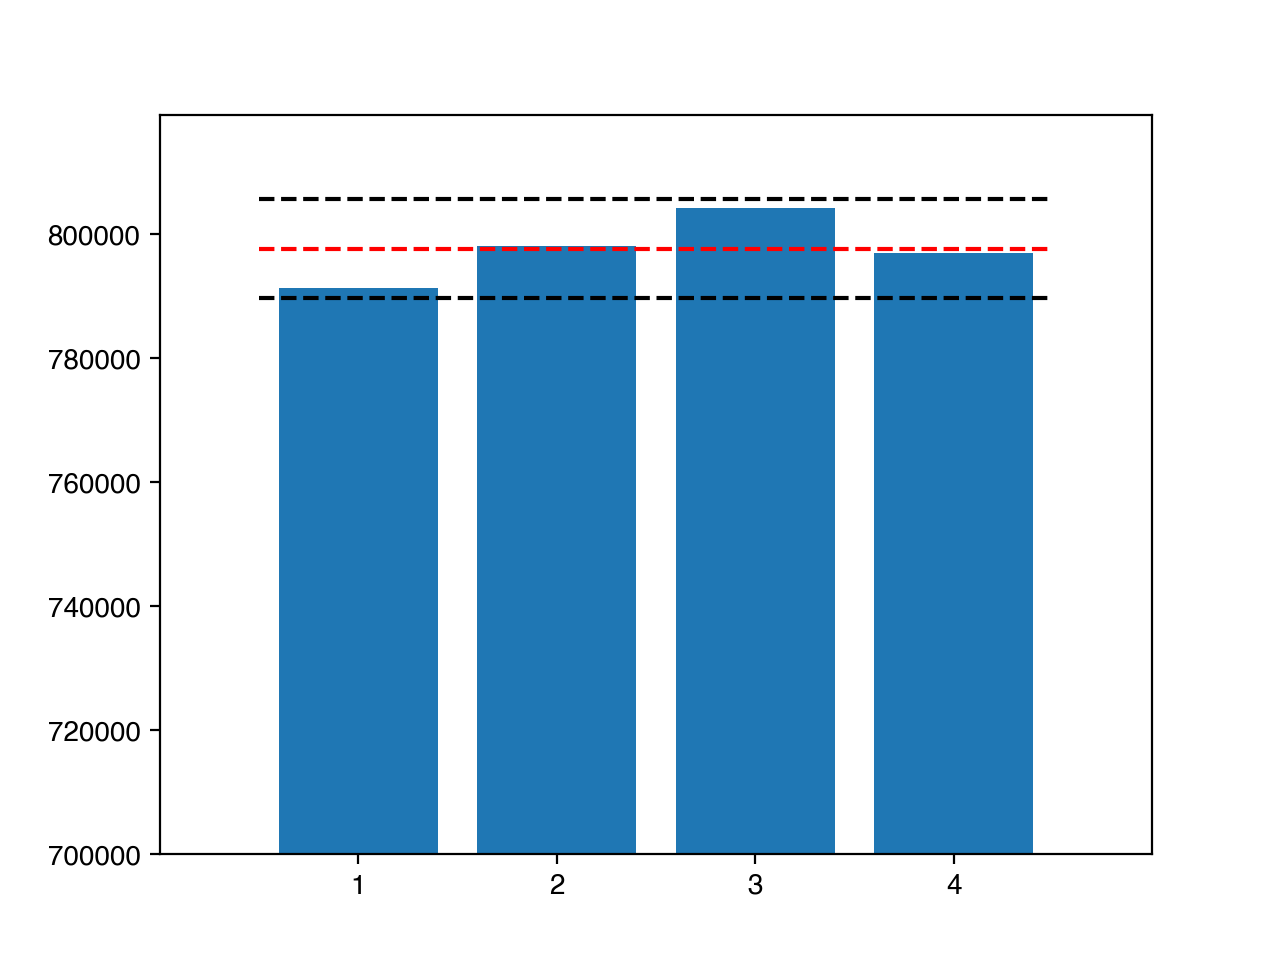

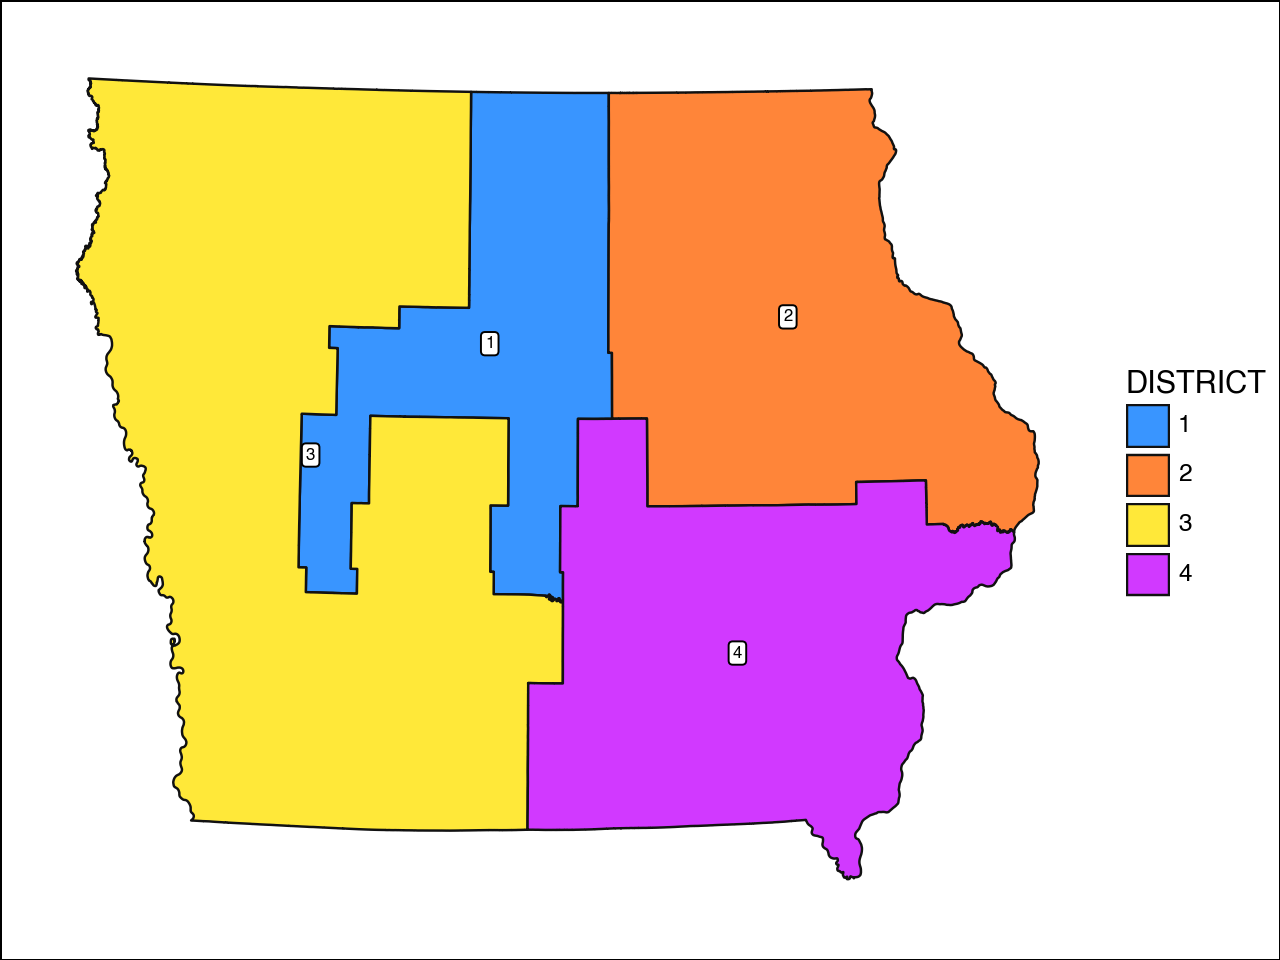

<Figure Size: (640 x 480)>

In [18]:
x=shapef_ia_redist['DISTRICT']
y=shapef_ia_redist['population']
# plt.bar(x, y)
fig, ax = plt.subplots()
district_min
ax.bar(x, y)
ax.set(xlim=(0, 5), xticks=np.arange(1, 5),
       ylim=(700000, max(y)+15000))
ax.plot([0.5, 4.5], [district_min, district_min], "k--")
ax.plot([0.5,4.5], [state_population/n_districts, state_population/n_districts], "r--")
ax.plot([0.5, 4.5], [district_max, district_max], "k--")

distmap_by_county(shapef_ia_redist, 'DISTRICT')

### graphing individual districts

In [19]:
# #this gives an example of output of map_unmerged_districts
# # map_unmerged_districts(list_of_counties[3],'NAME10')
# map_unmerged_districts(list_of_counties[2],'NAME10')
# # map_unmerged_districts(list_of_counties[1],'NAME10')
# map_unmerged_districts(list_of_counties[0],'NAME10')

## Compactness measures

Princeton Gerrymandering Project uses Reock (minimum bounding circle) and Polsby-Popper (perimeter) in their report cards
https://gerrymander.princeton.edu/redistricting-report-card-methodology

Polsby-Popper: $PP = \frac{\text{Area of district}}{\text{Area of circle with same perimeter as district}} = 4\pi \left(\frac{\text{Area of district}}{\text{(Perimeter of district)}^2}\right) $

Reock: $R = \frac{\text{Area of district}}{\text{Area of MBC}}$

(other metrics described here: https://fisherzachary.github.io/public/r-output.html)


(Skipping convex hull stuff (for now), but examples are at end of Linear_Programming/Iowa_redistricting_miniset_for_perim.ipynb)

In [20]:
def compactness_func(shapef_ia_redist):
    shapef_ia_compactness = shapef_ia_redist.copy()
    shapef_ia_compactness['area'] = shapef_ia_compactness['geometry'].area
    shapef_ia_compactness['perimeter'] = shapef_ia_compactness['geometry'].length
    #Polsby-Popper Score
    shapef_ia_compactness['PolsbyPopper']=4*math.pi*shapef_ia_compactness['area']/(shapef_ia_compactness['perimeter']**2)
    #radius of minimum bounding circle
    shapef_ia_compactness['min_bounding_radius']=shapef_ia_compactness['geometry'].minimum_bounding_radius()
    #Reock Score
    shapef_ia_compactness['Reock']=shapef_ia_compactness['area']/(math.pi*(shapef_ia_compactness['min_bounding_radius']**2))
    
    return shapef_ia_compactness

In [21]:
shapef_ia_compactness=compactness_func(shapef_ia_redist)
shapef_ia_compactness

,geometry,population,xcentr_lon,ycentr_lat,DISTRICT,area,perimeter,PolsbyPopper,min_bounding_radius,Reock
0,"POLYGON ((325806.676 4617350.979, 325806.682 4...",791221,431866.250842,4.706047e+06,1,2.001700e+10,9.953733e+05,0.253885,138320.309635,0.333025
1,"POLYGON ((519337.184 4654016.739, 519340.970 4...",798070,597473.585447,4.717830e+06,2,3.310850e+10,8.770632e+05,0.540863,149687.676300,0.470346
2,"POLYGON ((327366.139 4493729.314, 327331.113 4...",804149,332369.360825,4.657084e+06,3,6.021665e+10,1.729940e+06,0.252851,205312.143853,0.454713
3,"POLYGON ((452965.697 4501971.788, 452968.065 4...",796929,569474.933693,4.570007e+06,4,3.235594e+10,9.845112e+05,0.419491,150355.387434,0.455582


## Chen's algorithm for reallocation

From Chen's paper:

(3a) Among all pairs of districts that border one another, identify the pair with the greatest disparity in district population. Within this pair,
let us denote the more populated district as $i$ and the less populated district as $j$.

(3b) Identify the set of all precincts currently within district $i$ that could be reassigned to district $j$ without violating the geographic contiguity of either district $i$ or $j$.

(3c) For each precinct $p$ satisfying the criterion in step 3b, define $D_p$ as precinct $p$’s geographic distance to the centroid of district $i$, minus
precinct $p$’s distance to the centroid of district $j$.

(3d) Among the set of precincts satisfying the criteria in step 3b, select the precinct, $p$, with the highest value of Dp . Reassign this precinct from
district $i$ to district $j$.